<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Digital Wage Payment Prediction</h1> 
<h2 style="text-align: center;" markdown="2">An AIMS Masters project in Collaboration with the Global Centre on Digital Wages for Decent Work (ILO)</h2>


> *The widespread adoption of digital payments has become increasingly important. In light of this, the aim of this project is to investigate the probability of an individual receiving digital wages in Africa. To achieve this, a series of empirical comparative assessments of machine learning classification algorithms will be conducted. The objective is to determine the effectiveness of these algorithms in predicting digital wage payments. Therefore, this notebook forms part of a larger project that seeks to explore the potential of machine learning in addressing issues related to financial inclusion in Africa.*

<h1 style="text-align: center;" markdown="3">Advanced Algortihm 1: Simple Ensemble Average Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 1: Full Feature Dataset Merged</h2> 

# Table of Contents
[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Explanation and Theory](#introduction-theory)  
&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)  
[Data Setup](#setup)  
[Define a Simple Ensemble Average Classifier](#define-ensemble-function)  
&nbsp;&nbsp;&nbsp;[Ensemble the Top Models](#ensemble-top-models)  
&nbsp;&nbsp;&nbsp;[Average All Predictions](#average-preds)  
[Compare to Top Models](#compare)  
[Summary](#summary)

# Simple Ensemble Average Classifier Introduction <a class="anchor" id="introduction"></a>

Ensembling is a technique to combine multiple different kinds of classifiers. For example, you may want to combine a logistic regression and a random forest. There are many techniques that can be used to combine classifiers, of which averaging is the most straightforward. Ensembling is a common technique, and ensembles often perform better than individual model classes because one model can correct for another's error.

Constructing a simple ensemble average requires nothing more than predictions from more than one model. Combining predictions from multiple models offers a way of introducing heterogeneity of functional forms into a model pipeline without much additional complexity: one model may excel at utilizing certain patterns in the data, but be easily fooled by other patterns, while another model may have just the opposite properties. By combining the predictions from both, their best aspects can be amplified while their less helpful aspects can be mitigated.

In this notebook we will consider a simple (non-weighted) ensemble average of the top 10 models as ranked by their perforamnce on the Indonesia data. These models not only offer a variety of model classes, but have also been trained using various class-weighting techniques (under-sampling and over-sampling), which provides another level of heterogeneity.

## Explanation and Theory <a class="anchor" id="introduction-theory"></a>

**Assumptions and properties.** The component models of a simple ensemble average can have any properties, as long as they produce similarly structured predictions. The predictions from each model are then combined by some function to reduce the set of predictions to a single predicted output for each sample. 

**Algorithm and Training.** We will use the predicted class probabilities as the inputs to a standard arathmetic `mean` function so that each sample $i$ has $N$ predicted class probabilities, one from each of the $N$ models in the ensemble. Each component model is independently trained.


**Variations of the model.** If class probabilities are unavailable, then another technique such as "majority vote" could be used to reduce the set of predictions to one for each sample. Further, there are more advanced ways of ensembling such as _stacking_, in which predictions from the ensemble are used as input to another "second level" model. We will explore model stacking in the next notebook.

## Considerations <a class="anchor" id="introduction-considerations"></a>

Ensembling works best when the component models are heterogeneous. If very slight variations of the same model are used as the components in an ensemble, results are expected to be similar to those of a single model.

# Data setup <a class="anchor" id="setup"></a>

Since this type of ensembling relies on already-trained models, we could simply load the test data, models, predict, and combine. However, we will be using the prdictions from all models later in this series of notebooks. Therefore we will load the training and test data, and generate and save predictions from all samples.

First we load the standard libraries and data.

In [1]:
%matplotlib inline

import os
import sys
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from visualization import visualize
from data.load_data import (get_data_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize

ALGORITHM_NAME = 'ensemble'
COUNTRY = 'full_merged_dumvar'
TRAIN_PATH, TEST_PATH = get_data_filepaths(COUNTRY)

In [2]:
# load data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_test, y_test, w_test = load_data(TEST_PATH)

# Define a Simple Ensemble Averaging Model <a class="anchor" id="define-ensemble-function"></a>

To create an ensembled model, we'll need the predictions from the models that we want to include in the ensemble. We create a function `get_predictions_from_models` that will take a list of model names (that reference saved versions generated by other notebooks in this project) and creates a dataframe of the predictions the models make.

In [3]:
def get_predictions_from_models(list_of_models):
    # load the data
    country_dir = Path(evaluation.MODELS_DIR, COUNTRY)
    models = [evaluation.load_model(str(f.stem), COUNTRY)
              for f in country_dir.iterdir() if f.stem in list_of_models]
    
    # make predictions on training set
    all_preds_train = pd.DataFrame(np.zeros((X_train.shape[0], len(list_of_models))),
                             index=X_train.index,
                             columns=list_of_models).astype(float)
    all_preds_test = pd.DataFrame(np.zeros((X_test.shape[0], len(list_of_models))),
                             index=X_test.index,
                             columns=list_of_models).astype(float)
    
    # make preds on train and test
    for model in models:
        if 'feat' in model['name']:
            reduced_feat = model['features'].index.values
            X_train_reduced = X_train[reduced_feat]
            X_test_reduced = X_test[reduced_feat]
            all_preds_train[model['name']] = model['model'].predict_proba(X_train_reduced.to_numpy())[:, 1]
            all_preds_test[model['name']] = model['model'].predict_proba(X_test_reduced.to_numpy())[:, 1]
        else:
            all_preds_train[model['name']] = model['model'].predict_proba(X_train.to_numpy())[:, 1]
            all_preds_test[model['name']] = model['model'].predict_proba(X_test.to_numpy())[:, 1]

    
    # return all predictions for further evaluation
    return all_preds_train, all_preds_test

## Ensemble the Top Models <a class="anchor" id="ensemble-top-models"></a>

Here we pass a list of the top performing models to our ensembling generator, as determined by the comparisons presented in the results notebooks before this one.

Note that although some algorithm classes appear more than once, e.g., logistic regression (`lr`) and multi-layer-perception (`mlp`), each instance is different: some use over-sampling while some don't, some use cross-validation while some don't. This varition in training approaches should give us the heterogeneity we seek in a good ensemble model.

In [14]:
# top models selected from results notebook prior to this one
top_10 = [
    'rf_full_merged_cv_ada',
    'rf_full_merged_wts',
    'lr_full_merged_wts',
    'rf_full_merged',
    'rf_full_merged_wts_cv',
    'xgb_full_merged_wts_cv',
    'lr_full_merged_simple',
    'lr_full_merged_wts_cv',
    'svm_full_merged_simple',
    'rf_full_merged_simple',
]

Generate the prediction dataframe

In [15]:
all_preds_train, all_preds_test = get_predictions_from_models(top_10)

## Average All Predictions <a class="anchor" id="average-preds"></a>

As we can see here, we now have the probabilities that each model predicted for each household.

In [16]:
all_preds_test.head()

,rf_full_merged_cv_ada,rf_full_merged_wts,lr_full_merged_wts,rf_full_merged,rf_full_merged_wts_cv,xgb_full_merged_wts_cv,lr_full_merged_simple,lr_full_merged_wts_cv,svm_full_merged_simple,rf_full_merged_simple
5272,0.814298,0.832778,0.900822,0.74,0.893971,0.910611,0.926706,0.842842,0.910981,0.88
1807,0.917422,0.957914,0.953466,0.94,0.960714,0.954365,0.948974,0.923769,0.903074,0.99
895,0.006622,0.010395,0.024852,0.02,0.000175,0.002351,0.046670,0.015992,0.155221,0.02
4453,0.081400,0.076406,0.038913,0.07,0.019952,0.027000,0.078537,0.021230,0.189426,0.09
915,0.781430,0.846271,0.903588,0.78,0.844967,0.941052,0.878854,0.846971,0.855360,0.78


To generate a single prediction for each household, we take the mean over the columns (`axis=1`) of our prediction `DataFrame`. This is the simple averaging of predictions that creates the ensemble.

In [17]:
# round predictions to generate class predictions (using a 0.5 threshold)
simple_ensemble_preds = all_preds_test.mean(axis=1).round() 

# take mean of predictions to generate class probabilties
simple_ensemble_prob = all_preds_test.mean(axis=1)

A version of this function that has been included in the `src/models/ensemble` directory, and this version creates all the individual model predictions and also returns the mean of predictions (as we've done manually here).

#### Digital wage rate comparison

We can use the predictions generated by the ensemble to calculate the actual poverty rate and the predicted poverty rate.

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
# Make the ensemble predictions for train and test sets
ensemble_train = all_preds_train.mean(axis=1).round()
ensemble_test = all_preds_test.mean(axis=1).round()

# dataframe of the components needed for poverty rate prediction
dig_rate = pd.DataFrame(dict(
    wtg=np.concatenate([w_train, w_test]),
    receiver=np.concatenate([y_train, y_test]),
    pred=np.concatenate([ensemble_train, ensemble_test])
))

dig_rate_actual = (dig_rate.wtg * dig_rate.receiver).sum() / dig_rate.wtg.sum()

# Make predictions on entire dataset to get the predicted poverty rate
dig_rate_pred = (dig_rate.wtg * dig_rate.pred).sum() / dig_rate.wtg.sum()

print("\nActual dig rate: {:0.2%} ".format(dig_rate_actual))
print("Predicted dig rate: {:0.2%} ".format(dig_rate_pred))


Actual dig rate: 58.40% 
Predicted dig rate: 60.35% 


# Compare to Top Models <a class="anchor" id="compare"></a>

To gain a sense of the advantage of ensembling, let's compare the simple ensemble average to the performance of some of its component models. In order to avoid clutter in the plot, we have chosen only the top three models from the `top_10` list.

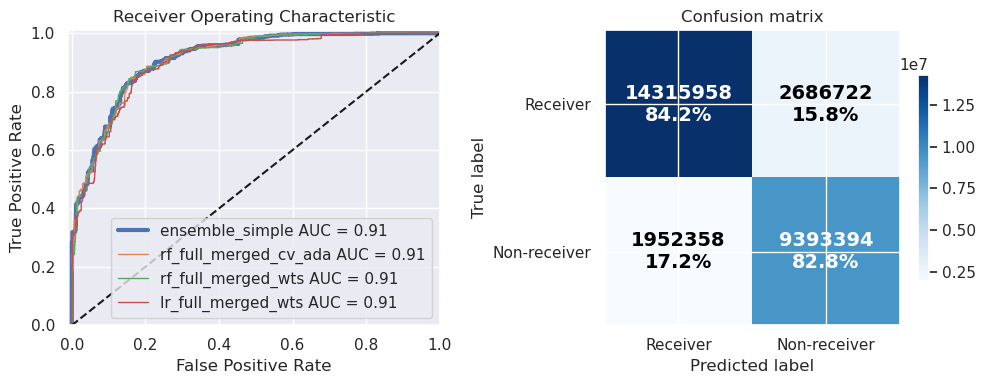

,ensemble_simple,rf_full_merged_cv_ada,rf_full_merged_wts,lr_full_merged_wts
accuracy,0.836355,0.841905,0.842592,0.839335
recall,0.841982,0.900862,0.916088,0.871582
precision,0.879990,0.845630,0.836900,0.862065
f1,0.860567,0.872373,0.874705,0.866797
cross_entropy,0.396253,0.368233,0.371675,0.378029
roc_auc,0.914100,0.912962,0.912324,0.905016
cohen_kappa,0.594221,0.577714,0.572456,0.590324


In [12]:
to_compare = ['rf_full_merged_cv_ada', 'rf_full_merged_wts', 'lr_full_merged_wts']
metrics = evaluation.evaluate_model(y_test, simple_ensemble_preds, simple_ensemble_prob, w_test, 
                                    compare_models=to_compare,
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    predict_dig_wage_rate=False,
                                   )

The simple ensemble average leads the group in area under the roc curve. However, the component models still outperform the ensemble in other metrics (recall not all components are shown here).

Let's see how the ensemble holds up against all of its component models.

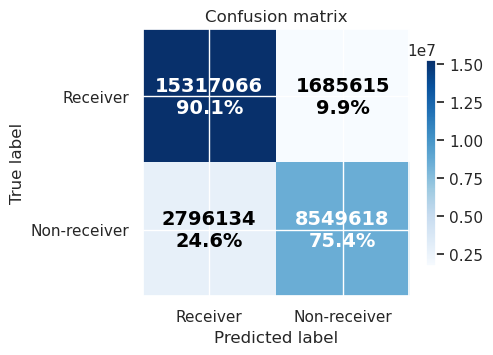

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,mean_rank
rf_full_merged_cv_ada,0.841905,0.900862,0.845630,0.872373,0.368233,0.912962,0.577714,3.142857
rf_full_merged_wts,0.842592,0.916088,0.836900,0.874705,0.371675,0.912324,0.572456,3.428571
rf_full_merged,0.841514,0.900948,0.845057,0.872108,0.375268,0.907723,0.568218,4.428571
ensemble_simple,0.836355,0.841982,0.879990,0.860567,0.396253,0.914100,0.594221,4.428571
lr_full_merged_wts,0.839335,0.871582,0.862065,0.866797,0.378029,0.905016,0.590324,4.571429
rf_full_merged_wts_cv,0.834983,0.927016,0.820977,0.870780,0.388575,0.901236,0.564072,6.428571
xgb_full_merged_wts_cv,0.819788,0.841723,0.855486,0.848549,0.387536,0.904917,0.542441,7.428571
lr_full_merged_simple,0.811295,0.880694,0.831967,0.855638,0.415427,0.880316,0.583907,7.571429
svm_full_merged_simple,0.809229,0.819957,0.871972,0.845165,0.430259,0.876288,0.597345,7.857143
lr_full_merged_wts_cv,0.817031,0.800974,0.883092,0.840031,0.413580,0.904628,0.544861,8.000000


In [20]:
metrics = [evaluation.load_model_metrics(f, COUNTRY) for f in top_10  + ['ensemble_simple']]
result = visualize.display_model_comparison(metrics, rank_order=True, transpose=True)

When we compare the ensemble to _all_ of its component models, we see that its rank outperforms its components on average. 

# Summary <a class="anchor" id="summary"></a>

If you already have a collection of trained models for some data set, the simple ensemble average is a relatively easy way to probably improve the overall performance of your classification pipeline.